In [62]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('bon', 4, 2)

In [4]:
from loren_frank_data_processing import get_interpolated_position_dataframe
from src.parameters import ANIMALS

In [5]:
from spectral_connectivity import Multitaper, Connectivity
from loren_frank_data_processing import get_LFP_dataframe, reshape_to_segments, make_tetrode_dataframe

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
        epoch_key, drop_level=False)

is_brain_areas = tetrode_info.area.isin(['CA1'])
is_brain_areas = is_brain_areas & tetrode_info.validripple
tetrode_keys = tetrode_info[is_brain_areas].index.tolist()

LFPs = [get_LFP_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in tetrode_keys]

tetrode_info[is_brain_areas].loc[:, ['area', 'depth', 'descrip']]

area    depth descrip
animal day epoch tetrode_number                      
bon    4   2     4               CA1  [[107]]     NaN
                 5               CA1  [[105]]     NaN
                 11              CA1   [[96]]     NaN
                 12              CA1  [[136]]     NaN
                 13              CA1   [[94]]     NaN
                 14              CA1   [[96]]     NaN
                 17              CA1  [[108]]     NaN
                 29              CA1  [[118]]     NaN

In [249]:
from ripple_detection import Kay_ripple_detector

hippocampus_lfps = pd.concat(
    [get_LFP_dataframe(tetrode_key, ANIMALS)
     for tetrode_key in tetrode_keys], axis=1, keys=tetrode_keys).astype(float).resample('1ms').mean().dropna()
time = hippocampus_lfps.index

def _time_function(epoch_key, animals):
    return time

speed = get_interpolated_position_dataframe(
    epoch_key, ANIMALS, _time_function).speed

sampling_frequency = 1000

ripple_times = Kay_ripple_detector(
        time, hippocampus_lfps.values, speed.values, sampling_frequency,
        minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=2)

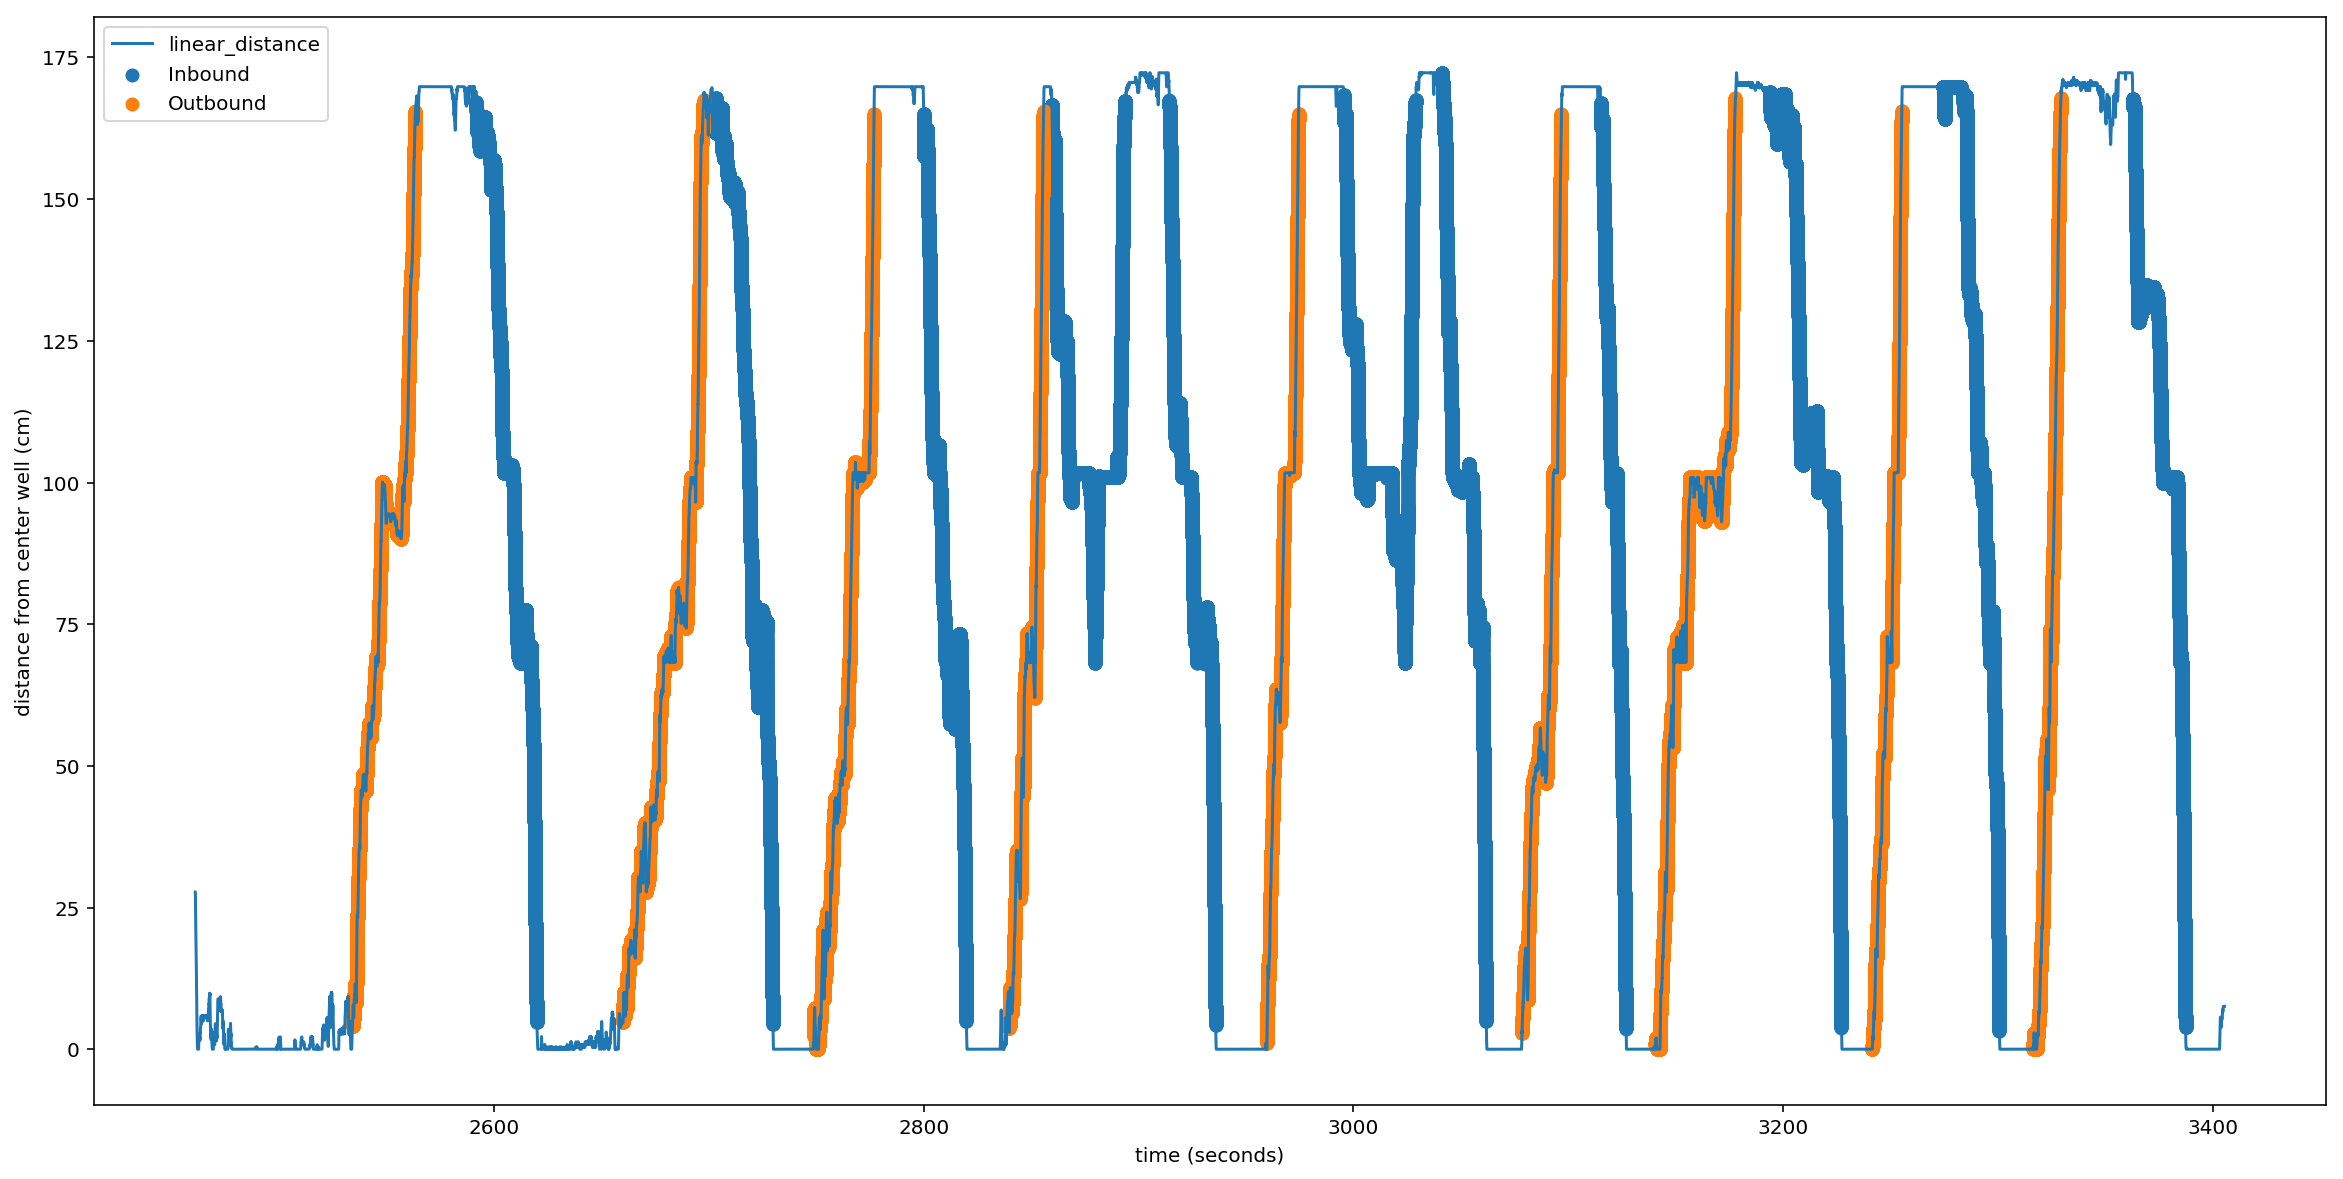

In [7]:
position_info = get_interpolated_position_dataframe(
    epoch_key, ANIMALS, time_function=_time_function, max_distance_from_well=5)

plt.figure(figsize=(20, 10))
plt.plot(position_info.index.total_seconds(), position_info.linear_distance)

for label, df in position_info.groupby('task'):
    plt.scatter(df.index.total_seconds(), df.linear_distance, label=label)

plt.xlabel('time (seconds)')
plt.ylabel('distance from center well (cm)')
plt.legend();

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)


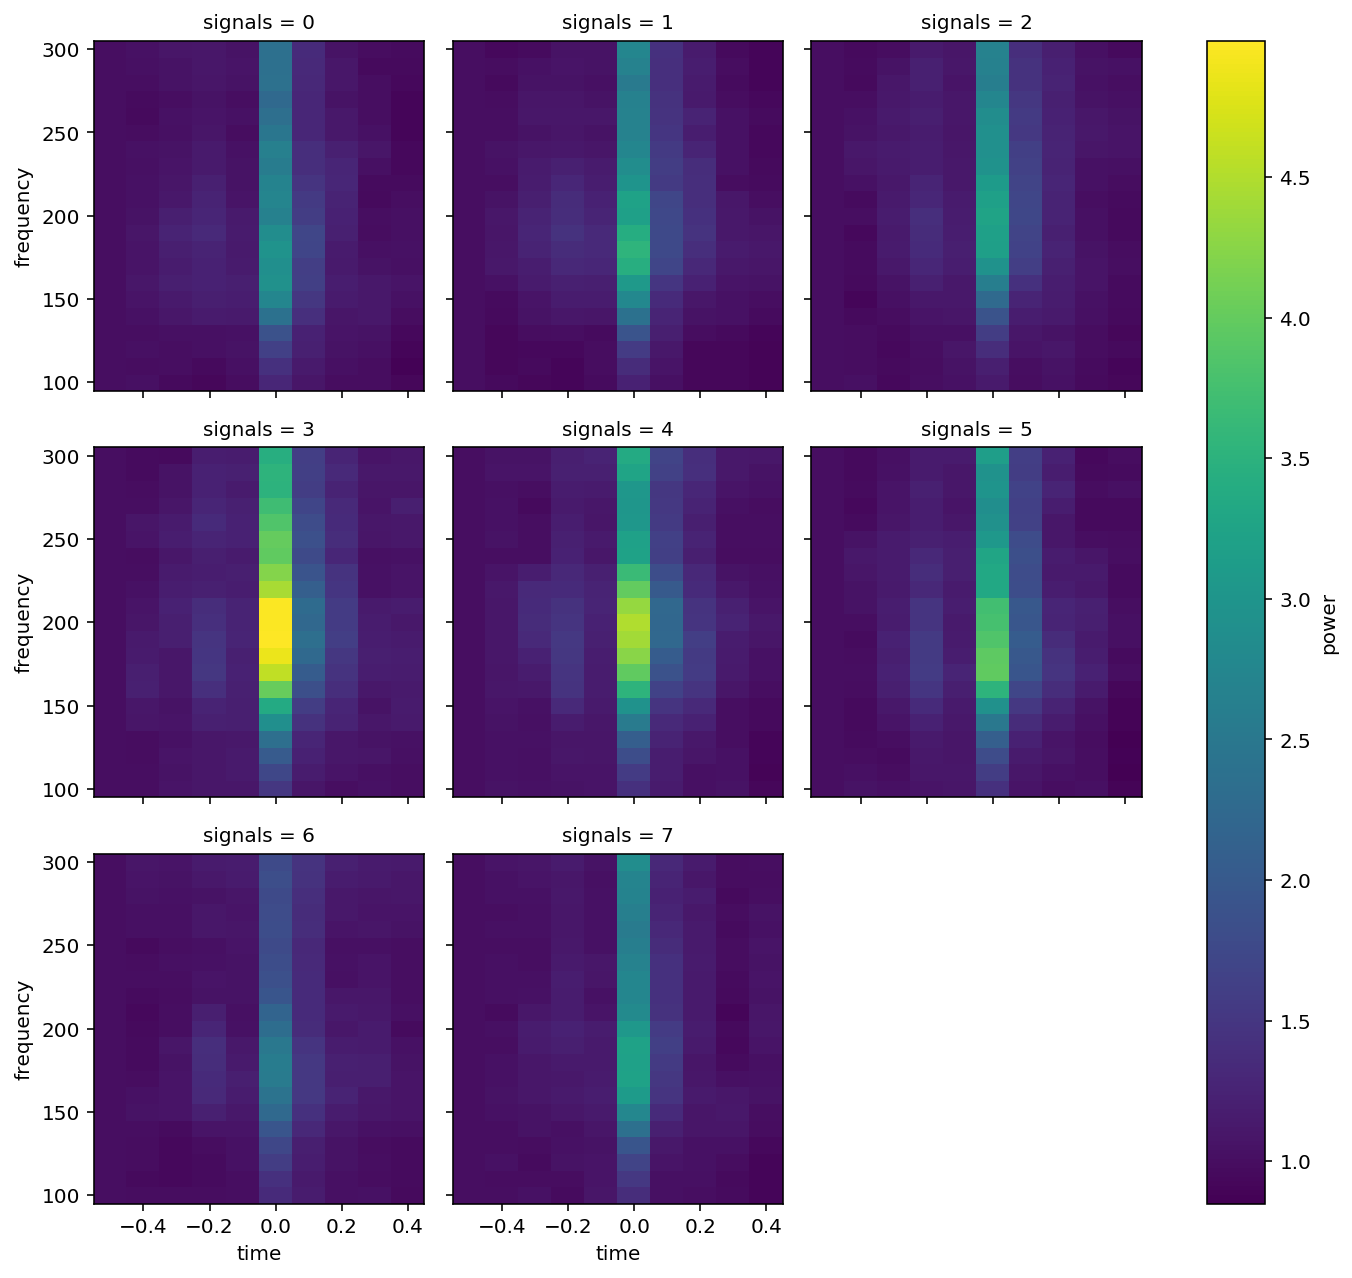

In [8]:
window_offset = (-0.5, 0.5)

ripple_locked_LFPs = reshape_to_segments(hippocampus_lfps, ripple_times, window_offset=window_offset)
data = (ripple_locked_LFPs.to_panel().to_xarray().transpose('minor_axis', 'major_axis', 'items').values)
ripple_time = ripple_locked_LFPs.unstack(level=0).index.get_level_values('time').total_seconds().values
m = Multitaper(data, sampling_frequency, time_window_duration=0.100,
               time_halfbandwidth_product=3, start_time=ripple_time[0])
c = Connectivity.from_multitaper(m)
power = xr.DataArray(c.power(), dims=('time', 'frequency', 'signals'), coords=dict(time=c.time, frequency=c.frequencies), name='power')
(power / power.isel(time=0)).sel(frequency=slice(100, 300)).plot(x='time', y='frequency', col='signals', col_wrap=3);

In [9]:
m = Multitaper(hippocampus_lfps.values, sampling_frequency, time_window_duration=0.020,
               time_halfbandwidth_product=1, start_time=time.total_seconds()[0])
c = Connectivity.from_multitaper(m)
ripple_power = xr.DataArray(c.power(), dims=('time', 'frequency', 'signals'),
                            coords=dict(time=pd.TimedeltaIndex(c.time, unit='s'), frequency=c.frequencies), name='power')
ripple_power = ripple_power.sel(frequency=200).reindex(time)
ripple_power /= ripple_power.mean('time')
ripple_locked_power = reshape_to_segments(ripple_power.drop('frequency').to_dataframe().unstack(), ripple_times, window_offset)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=2460.9958, n_tapers=1)


In [10]:
ripple_duration = ripple_times.end_time.dt.total_seconds() - ripple_times.start_time.dt.total_seconds()

In [11]:
from ripple_detection.core import filter_ripple_band

ripple_filtered_LFPs = pd.DataFrame(
    np.stack([filter_ripple_band(lfp, sampling_frequency) for lfp in hippocampus_lfps.values.T], axis=1),
    index=time, columns=tetrode_keys)

ripple_locked_filtered_LFPs = reshape_to_segments(ripple_filtered_LFPs, ripple_times, window_offset=window_offset)

In [15]:
from ipywidgets import interact

def plot_lfp(ripple_number=1):
    n_LFPs = hippocampus_lfps.shape[1]
    fig, axes = plt.subplots(n_LFPs, 3, figsize=(20, 10), sharex=True)
    for ax, lfp in zip(
            axes[:, 0], ripple_locked_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp)
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    for ax, lfp in zip(
            axes[:, 1], ripple_locked_filtered_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp, color='orange')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    power_time = ripple_locked_power.loc[ripple_number].index.total_seconds().values
    for ax, p in zip(axes[:, 2], ripple_locked_power.loc[ripple_number].values.T):
        ax.plot(power_time, p, color='purple')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(1, color='black', linestyle='--')

    axes[0, 0].set_title('LFP')
    axes[0, 1].set_title('Bandpass Filtered LFP (150 - 250 Hz)')
    axes[0, 2].set_title('Ripple Power Change');

n_ripples = len(ripple_times)
interact(plot_lfp, ripple_number=(1, n_ripples), continuous_update=False);

interactive(children=(IntSlider(value=1, description='ripple_number', max=284, min=1), Output()), _dom_classes=('widget-interact',))

In [250]:
from loren_frank_data_processing import make_neuron_dataframe, get_spike_indicator_dataframe

neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False).loc[:, ['area', 'numspikes']].dropna()
neuron_info = neuron_info.loc[neuron_info.numspikes > 0]

In [251]:
spikes_data = pd.concat([get_spike_indicator_dataframe(neuron_key, ANIMALS, time_function=_time_function)
               for neuron_key in neuron_info.index], axis=1)
ripple_locked_spikes = reshape_to_segments(spikes_data, ripple_times, window_offset)

In [342]:
def plot_neurons_by_ripple(ripple_number):
    ripple_spikes = np.nonzero(ripple_locked_spikes.loc[ripple_number].fillna(0.0).values)
    n_neurons = len(neuron_info)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(ripple_time[ripple_spikes[0]], ripple_spikes[1], s=10)
    ax.set_yticks(np.arange(n_neurons))
    ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
    ax.set_yticklabels(neuron_info.area.values);
    ax.set_xlim(window_offset)

interact(plot_neurons_by_ripple, ripple_number=(1, n_ripples));

interactive(children=(IntSlider(value=142, description='ripple_number', max=284, min=1), Output()), _dom_classes=('widget-interact',))

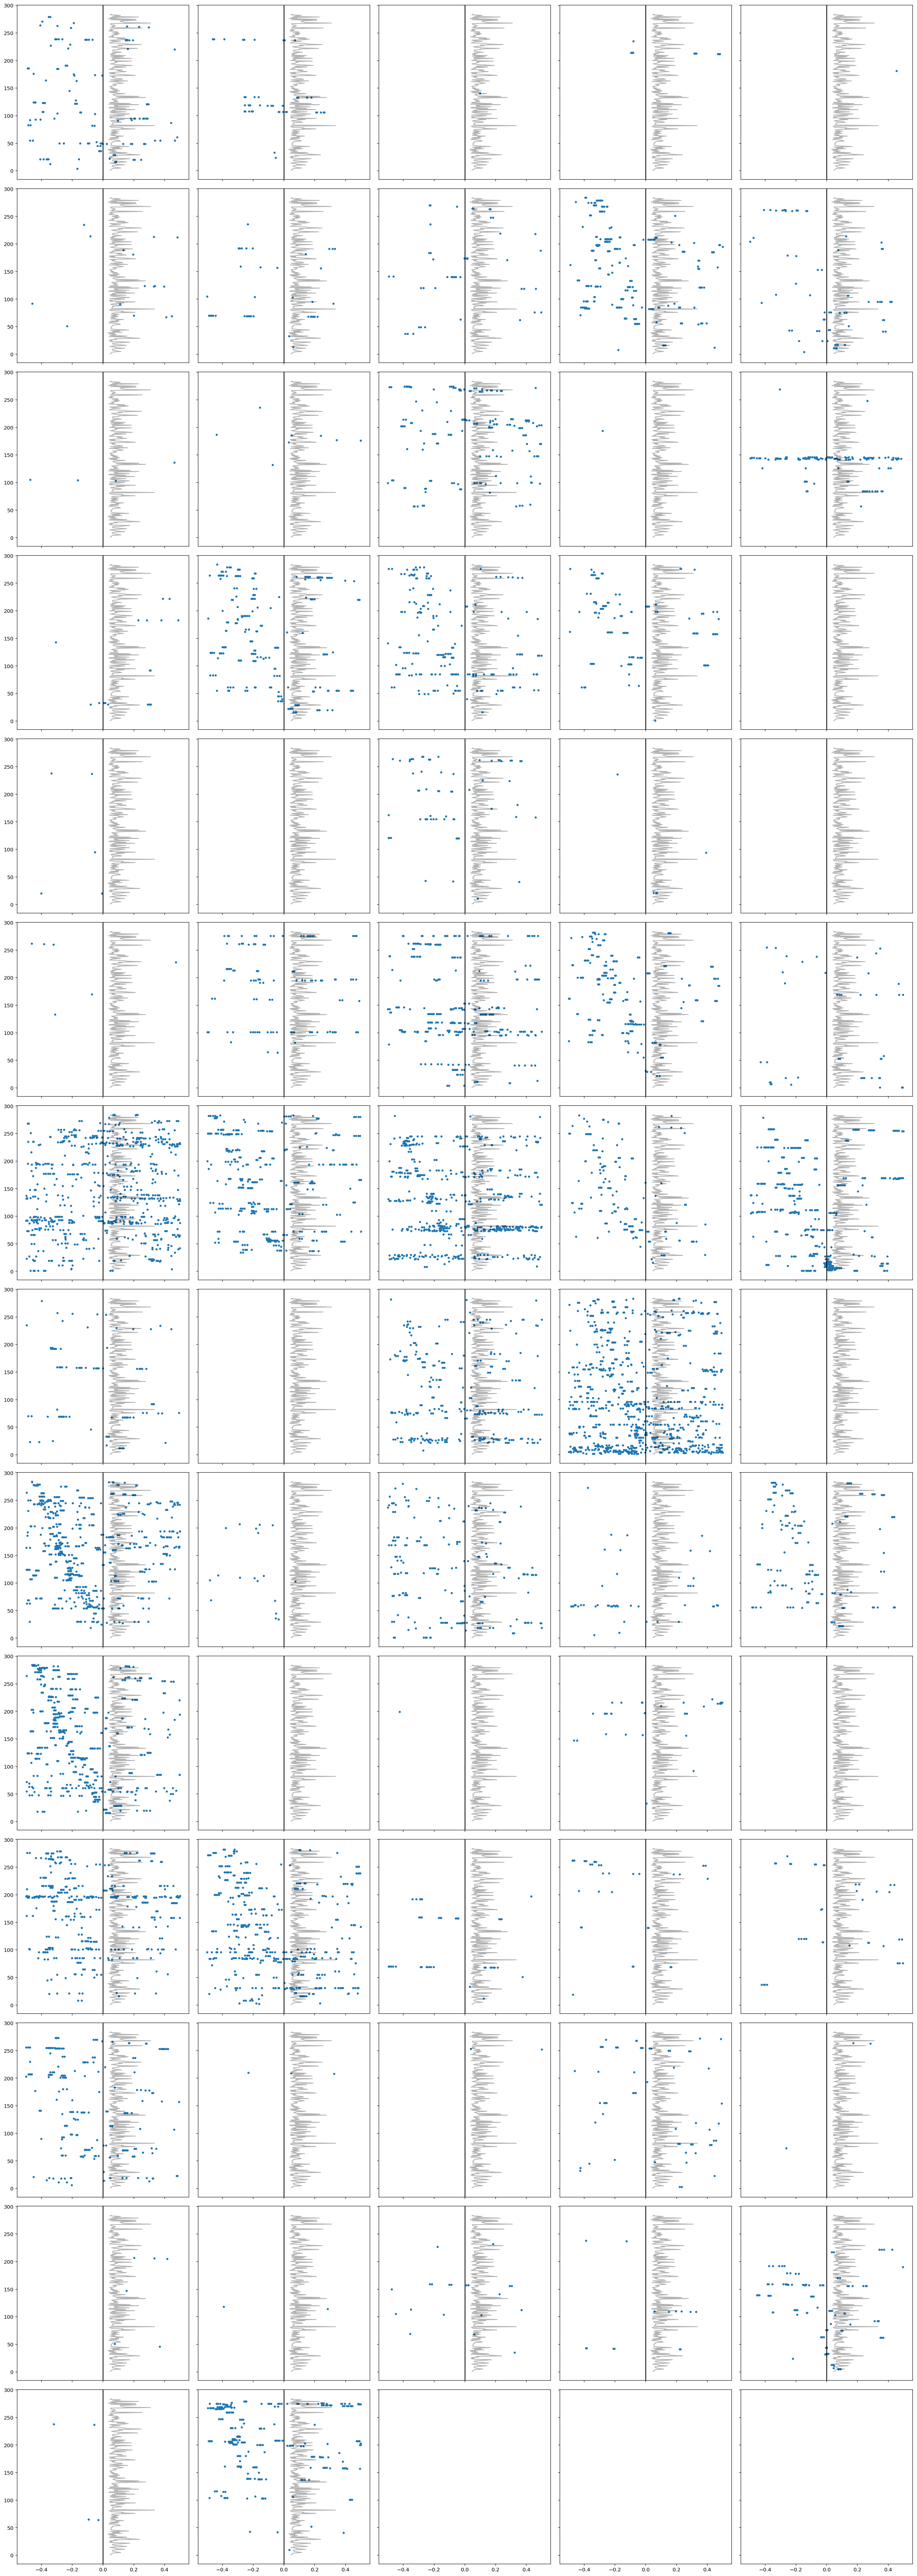

In [355]:
n_neurons = len(neuron_info)
n_ripples = len(ripple_times)
n_rows = int(np.ceil(n_neurons / 5))

fig, axes = plt.subplots(n_rows, 5, figsize=(25, n_rows * 5), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_info.index):
    try:
        spikes = get_spike_indicator_dataframe(neuron_key, ANIMALS, time_function=_time_function)
        ripple_locked_spikes = reshape_to_segments(
            spikes, ripple_times, window_offset).dropna()
        df = ripple_locked_spikes.unstack(level=0)
        neuron_ripple_spikes = np.nonzero(df.fillna(0.0).values)
        t = df.index.total_seconds().values
        ax.scatter(t[neuron_ripple_spikes[0]], neuron_ripple_spikes[1] + 1, s=10)
        ax.plot(ripple_duration.values, ripple_duration.index.values, color='black', alpha=0.3)
        ax.axvline(0.0, color='black')
        ax.set_title(neuron_info.area[neuron_ind])
        ax.set_ylabel('ripple number')
        ax.set_xlabel('time')
        ax.set_ylim((0, n_ripples + 1))
        ax.set_xlim(window_offset)
    except IndexError:
        pass
    
plt.tight_layout()


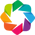

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Categorize-Replay-2017/src/../Raw-Data/Bond/EEG/boneeg04-2-09.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Categorize-Replay-2017/src/../Raw-Data/Bond/EEG/boneeg04-2-16.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Categorize-Replay-2017/src/../Raw-Data/Bond/EEG/boneeg04-2-26.mat
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


animal area  day    depth descrip  epoch  \
animal day epoch tetrode_number                                            
bon    4   2     4                 bon  CA1    4  [[107]]     NaN      2   
                 5                 bon  CA1    4  [[105]]     NaN      2   
                 11                bon  CA1    4   [[96]]     NaN      2   
                 12                bon  CA1    4  [[136]]     NaN      2   
                 13                bon  CA1    4   [[94]]     NaN      2   
                 14                bon  CA1    4   [[96]]     NaN      2   
                 17                bon  CA1    4  [[108]]     NaN      2   
                 29                bon  CA1    4  [[118]]     NaN      2   

                                hemisphere  maxcell  nearCA2  numcells  \
animal day epoch tetrode_number                                          
bon    4   2     4                   right      NaN      0.0       2.0   
                 5                   right      NaN      0.0       5.0   
                 11                  right      NaN      0.0       6.0   
                 12                   left      NaN      0.0       4.0   
                 13                   left      NaN      0.0       4.0   
                 14                   left      1.0      0.0       8.0   
                 17                   left      NaN      0.0       2.0   
                 29                  right      NaN      0.0       4.0   

                                 representative subarea     tetrode_id  \
animal day epoch tetrode_number                                          
bon    4   2     4                          NaN    CA1c  bon_04_02_004   
                 5                          NaN    CA1c  bon_04_02_005   
                 11                         NaN    CA1c  bon_04_02_011   
                 12                         NaN    CA1c  bon_04_02_012   
                 13                         NaN    CA1c  bon_04_02_013   
                 14                         1.0    CA1c  bon_04_02_014   
                 17                         NaN    CA1c  bon_04_02_017   
                 29                         NaN    CA1c  bon_04_02_029   

                                 tetrode_number  validripple  
animal day epoch tetrode_number                               
bon    4   2     4                            4          1.0  
                 5                            5          1.0  
                 11                          11          1.0  
                 12                          12          1.0  
                 13                          13          1.0  
                 14                          14          1.0  
                 17                          17          1.0  
                 29                          29          1.0

In [40]:
from loren_frank_data_processing import (get_interpolated_position_dataframe,
                                         get_LFP_dataframe,
                                         get_multiunit_indicator_dataframe,
                                         get_spike_indicator_dataframe,
                                         make_neuron_dataframe,
                                         make_tetrode_dataframe,
                                         reshape_to_segments, save_xarray)
from replay_classification import ClusterlessDecoder, SortedSpikeDecoder

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False)
brain_areas_tetrodes = tetrode_info[
    tetrode_info.area.isin(['CA1']) &
    tetrode_info.validripple]

mark_names = get_multiunit_indicator_dataframe(
    brain_areas_tetrodes.index[0], ANIMALS).columns.tolist()
mark_names = [mark_name for mark_name in mark_names
              if mark_name not in ['x_position', 'y_position']]
mark_names = mark_names[:4]
marks = [(get_multiunit_indicator_dataframe(tetrode_key, ANIMALS, time_function=_time_function)
      .loc[:, mark_names])
     for tetrode_key in brain_areas_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
     if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
         .shape[0]) != 0]

train_position_info = position_info.query('speed > 4')

training_marks = np.stack([
    tetrode_marks.loc[train_position_info.index, mark_names]
    for tetrode_marks in marks], axis=0)

n_position_bins = 61
place_std_deviation = 20
mark_std_deviation = 20

decoder = ClusterlessDecoder(
        train_position_info.linear_distance.values,
        train_position_info.task.values,
        training_marks,
        n_position_bins=n_position_bins,
        place_std_deviation=place_std_deviation,
        mark_std_deviation=mark_std_deviation,
        replay_speedup_factor=16,
    ).fit()

display(brain_areas_tetrodes)

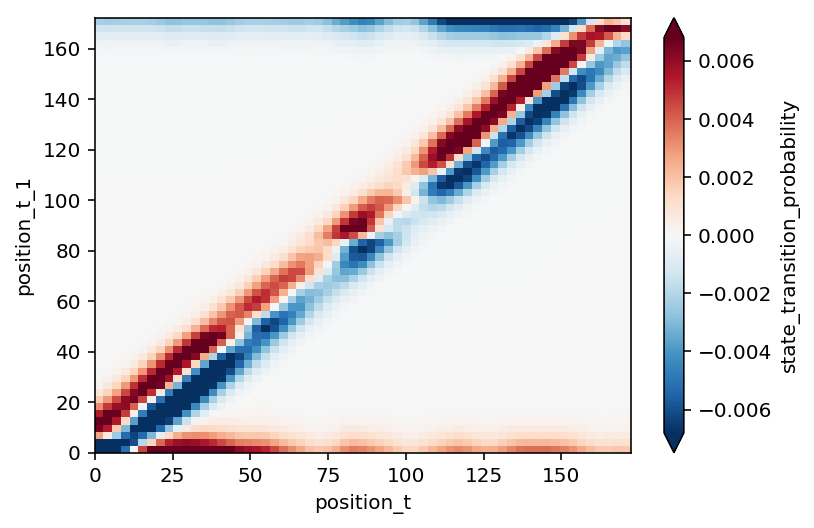

In [41]:
(decoder.state_transition_matrix.sel(state='Inbound-Forward') -
 decoder.state_transition_matrix.sel(state='Outbound-Forward')).plot(x='position_t', y='position_t_1', robust=True)

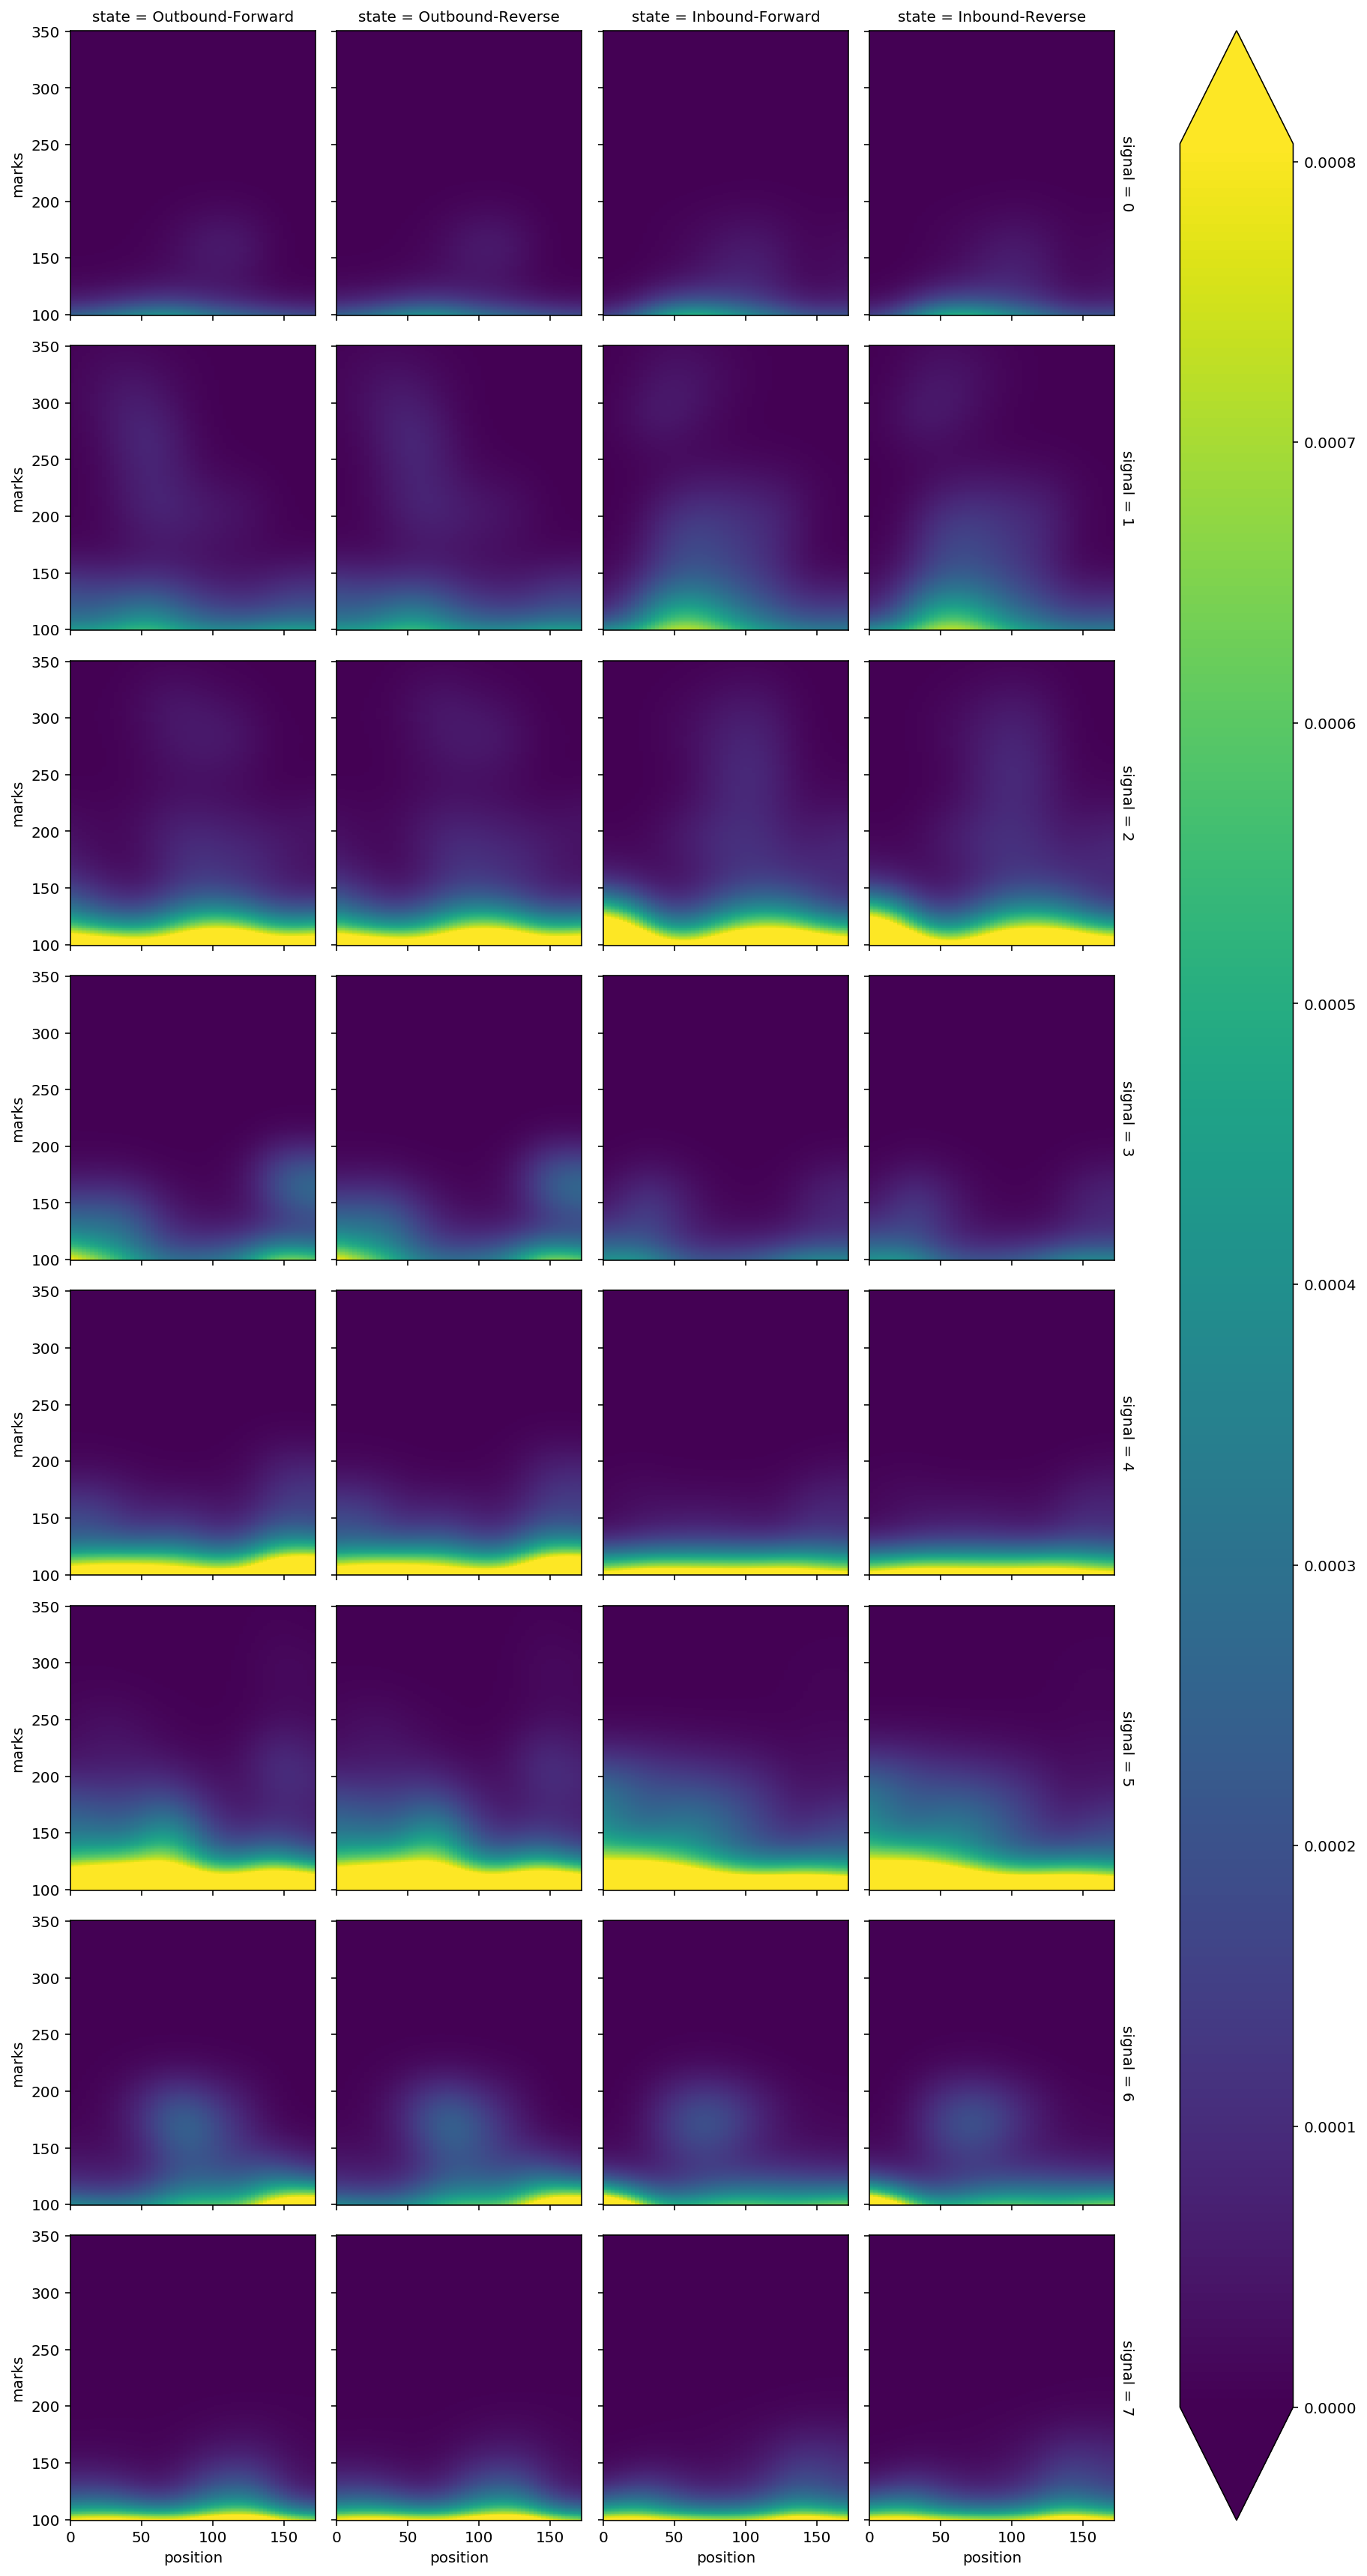

In [42]:
decoder.plot_observation_model()

In [43]:
from src.analysis import _get_ripple_marks

test_marks = _get_ripple_marks(marks, ripple_times)
results = [decoder.predict(ripple_marks, time.total_seconds())
           for ripple_marks, time in test_marks]

In [45]:
from src.analysis import summarize_replay_results

(replay_info, decision_state_probability,
            posterior_density) = summarize_replay_results(
        results, ripple_times, position_info, epoch_key)

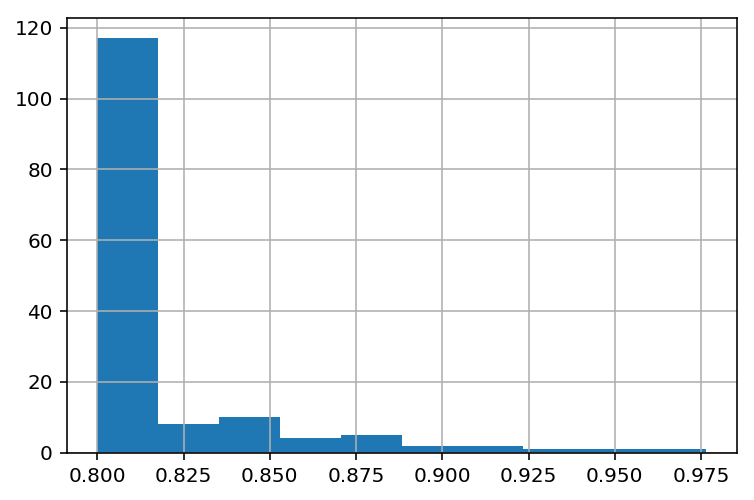

In [46]:
replay_info.predicted_state_probability.hist()

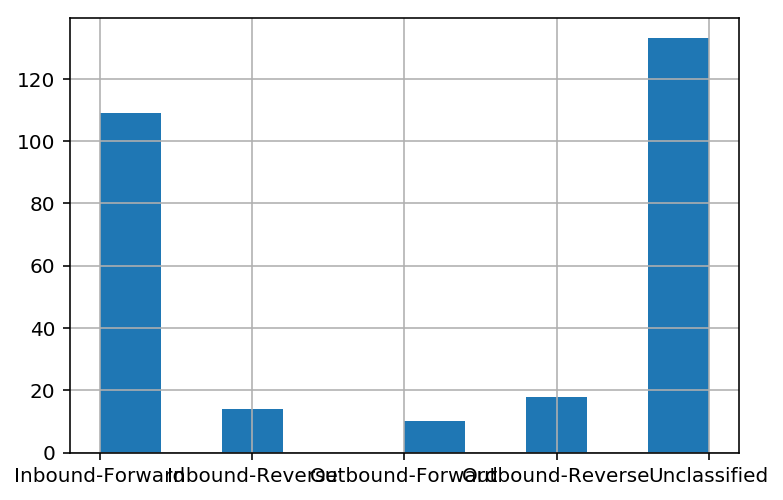

In [47]:
replay_info.predicted_state.hist()

In [72]:
def plot_posterior(ripple_number):
    g = posterior_density.isel(concat_dim=ripple_number).dropna('time').plot(
        x='time', y='position', col='state', col_wrap=2, robust=True, vmin=0);
    rat_position = replay_info.loc[ripple_number].linear_distance
    for ax in g.axes.ravel():
        ax.axhline(rat_position, color='white', linestyle='--', linewidth=3)
    plt.figure()
    plt.plot(position_info.x_position.values, position_info.y_position.values)
    plt.scatter(replay_info.loc[ripple_number].x_position,
                replay_info.loc[ripple_number].y_position, color='red', zorder=100, s=100)
    plot_lfp(ripple_number)
interact(plot_posterior, ripple_number=(0, len(ripple_times)-1), continuous_update=False);

interactive(children=(IntSlider(value=141, description='ripple_number', max=283), Output()), _dom_classes=('widget-interact',))

In [61]:
neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = pd.merge(tetrode_info, neuron_info,
                       on=['animal', 'day', 'epoch',
                           'tetrode_number', 'area'],
                       how='right', right_index=True).set_index(
    neuron_info.index)
neuron_info = neuron_info[
    neuron_info.area.isin(['CA1']) &
    neuron_info.validripple & neuron_info.numspikes > 0]
spikes_data = [get_spike_indicator_dataframe(neuron_key, ANIMALS, time_function=_time_function)
               for neuron_key in neuron_info.index]

# Make sure there are spikes in the training data times. Otherwise
# exclude that neuron
spikes_data = [spikes_datum for spikes_datum in spikes_data
               if spikes_datum[
                   position_info.speed > 4].sum() > 0]

train_spikes_data = [spikes_datum[position_info.speed > 4]
                     for spikes_datum in spikes_data]
decoder_sortedspikes = SortedSpikeDecoder(
    position=train_position_info.linear_distance.values,
    spikes=np.stack(train_spikes_data, axis=0),
    trajectory_direction=train_position_info.task.values,
    n_position_bins=n_position_bins,
    replay_speedup_factor=16,
).fit()

display(neuron_info)

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


KeyboardInterrupt: 